# Outil de Scoring client
Société : Prêt à dépenser  
Domaine : probabilité qu'un client rembourse un crédit OUI/NON  
Auteur : ERiC LAURENT  
Février/Mars 2022

In [151]:
# Les librairies de base
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [152]:
# Suppression des warnings
import warnings
warnings.filterwarnings('ignore')

In [153]:
# Fonction qui retourne la définition des features
def definition_feature(feature):
    pd.set_option("max_colwidth", None)
    res=HomeCredit_columns_description[['Table','Description']][(HomeCredit_columns_description.Row==feature)]
    return res
    pd.reset_option("max_colwidth")

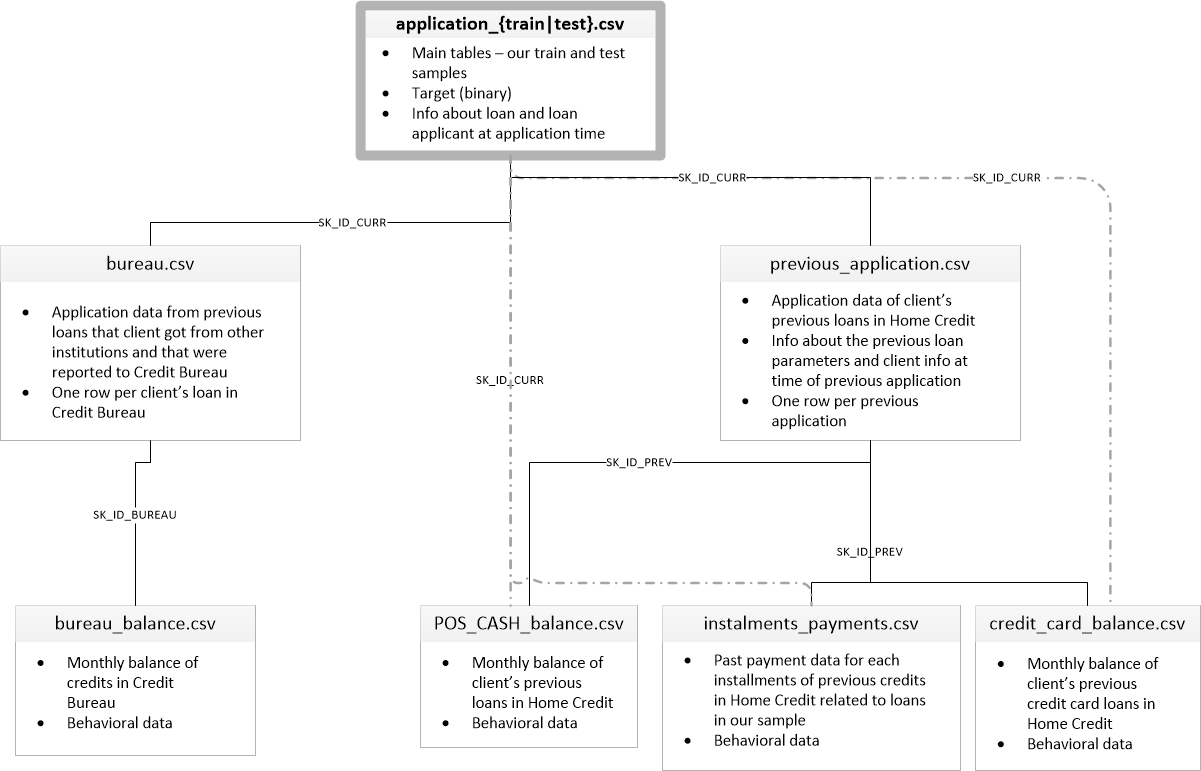

In [154]:
# Le modèle de la base de données
from IPython.display import Image
Image("../dataSource/MCD.png")

In [155]:
# Import des données sous forme de dataframe (df)
application_test=pd.read_csv("../dataSource/application_test.csv")
application_train=pd.read_csv("../dataSource/application_train.csv")
bureau=pd.read_csv("../dataSource/bureau.csv")
bureau_balance=pd.read_csv("../dataSource/bureau_balance.csv")
credit_card_balance=pd.read_csv("../dataSource/credit_card_balance.csv")
HomeCredit_columns_description=pd.read_csv("../dataSource/HomeCredit_columns_description.csv")  # Erreur de chargement, mettre num pour la première colonne dans le fichier brut
installments_payments=pd.read_csv("../dataSource/installments_payments.csv")
POS_CASH_balance=pd.read_csv("../dataSource/POS_CASH_balance.csv")
previous_application=pd.read_csv("../dataSource/previous_application.csv")
sample_submission=pd.read_csv("../dataSource/sample_submission.csv")

# Nettoyage et Exploration de données

In [156]:
# Taille des df disponibles
for nom_df,df in zip(['application_test','application_train','bureau','bureau_balance','credit_card_balance','HomeCredit_columns_description',
    'installments_payments','POS_CASH_balance','previous_application','sample_submission'],
    (application_test,application_train,bureau_balance,bureau,credit_card_balance,HomeCredit_columns_description,installments_payments,POS_CASH_balance,previous_application,sample_submission)):
    print(f'DataFrame : {nom_df} | taille (lignes,colonnes) = {df.shape}')

DataFrame : application_test | taille (lignes,colonnes) = (48744, 121)
DataFrame : application_train | taille (lignes,colonnes) = (307511, 122)
DataFrame : bureau | taille (lignes,colonnes) = (27299925, 3)
DataFrame : bureau_balance | taille (lignes,colonnes) = (1716428, 17)
DataFrame : credit_card_balance | taille (lignes,colonnes) = (3840312, 23)
DataFrame : HomeCredit_columns_description | taille (lignes,colonnes) = (219, 5)
DataFrame : installments_payments | taille (lignes,colonnes) = (13605401, 8)
DataFrame : POS_CASH_balance | taille (lignes,colonnes) = (10001358, 8)
DataFrame : previous_application | taille (lignes,colonnes) = (1670214, 37)
DataFrame : sample_submission | taille (lignes,colonnes) = (48744, 2)


In [157]:
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


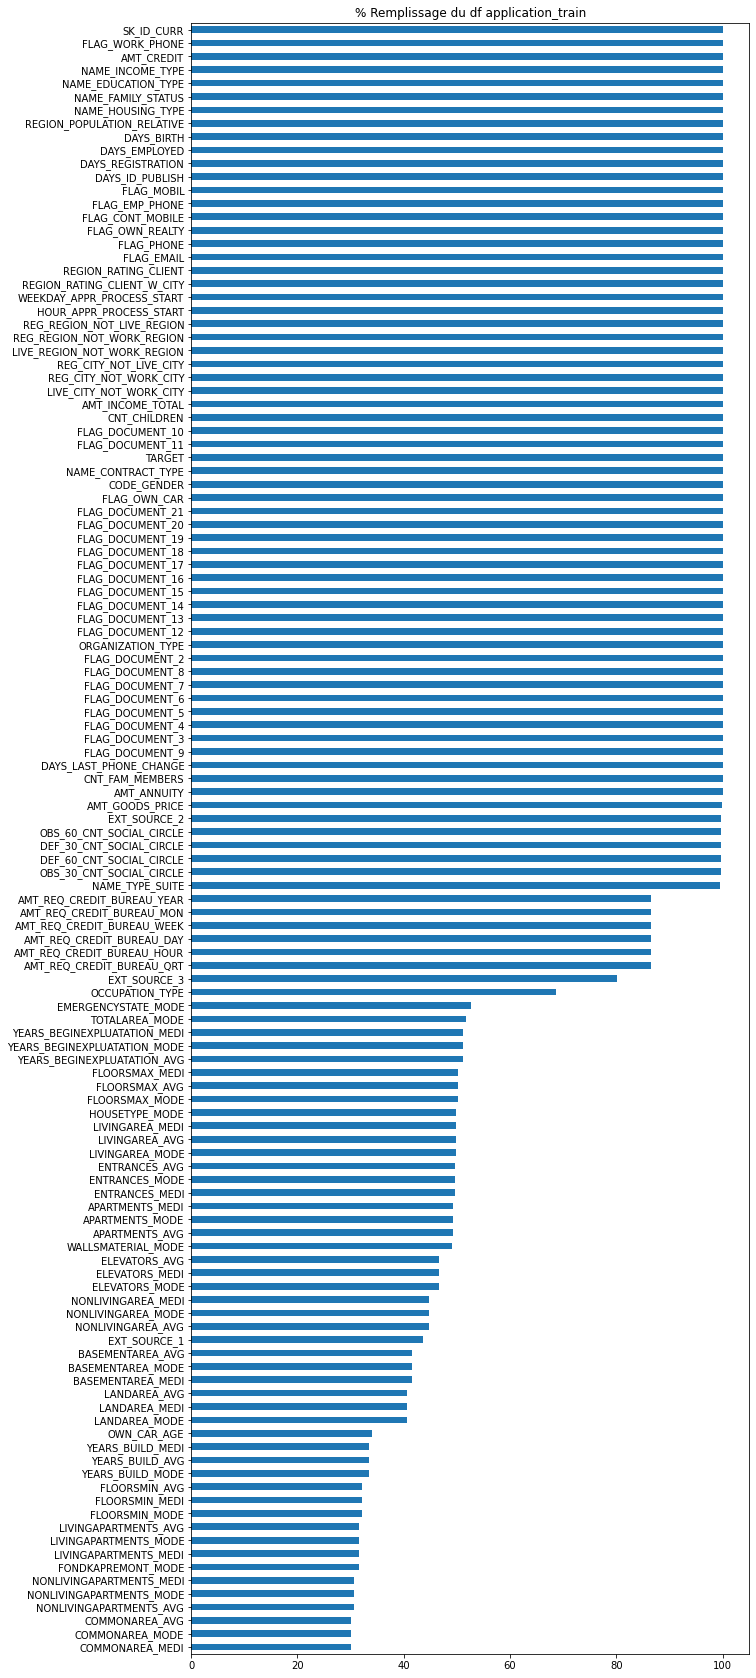

In [158]:
# Remplissage du df application_train en %
((1-application_train.isna())*100).mean().sort_values().plot.barh(figsize=(10,30),fontsize=10)
plt.title('% Remplissage du df application_train')
plt.show()

Il faudra s'efforcer de prendre les features les mieux renseignées.

In [159]:
# Choix des features à conserver : la target et ce qui peut être significatif pour prédire le remboursement ou non du crédit.
choix_features=[
'TARGET',   
'SK_ID_CURR',
#'NAME_CONTRACT_TYPE',
#'CODE_GENDER',
'FLAG_OWN_CAR',
'FLAG_OWN_REALTY',
'CNT_CHILDREN',
'AMT_INCOME_TOTAL',
'AMT_CREDIT',
'AMT_ANNUITY',
'AMT_GOODS_PRICE',
#'NAME_TYPE_SUITE',
#'NAME_INCOME_TYPE',
'NAME_EDUCATION_TYPE',
'NAME_FAMILY_STATUS',
#'NAME_HOUSING_TYPE',
#'REGION_POPULATION_RELATIVE',
'DAYS_BIRTH',
#'DAYS_EMPLOYED',
#'DAYS_REGISTRATION',
#'DAYS_ID_PUBLISH',
#'OWN_CAR_AGE',
#'FLAG_MOBIL',
#'FLAG_EMP_PHONE',
#'FLAG_WORK_PHONE',
#'FLAG_CONT_MOBILE',
#'FLAG_PHONE',
#'FLAG_EMAIL',
#'OCCUPATION_TYPE',
#'CNT_FAM_MEMBERS',
#'REGION_RATING_CLIENT',
#'REGION_RATING_CLIENT_W_CITY',
#'WEEKDAY_APPR_PROCESS_START',
#'HOUR_APPR_PROCESS_START',
#'REG_REGION_NOT_LIVE_REGION',
#'REG_REGION_NOT_WORK_REGION',
#'LIVE_REGION_NOT_WORK_REGION',
#'REG_CITY_NOT_LIVE_CITY',
#'REG_CITY_NOT_WORK_CITY',
#'LIVE_CITY_NOT_WORK_CITY',
#'ORGANIZATION_TYPE',
'EXT_SOURCE_1',
'EXT_SOURCE_2',
'EXT_SOURCE_3',
#'APARTMENTS_AVG',
#'BASEMENTAREA_AVG',
#'YEARS_BEGINEXPLUATATION_AVG',
#'YEARS_BUILD_AVG',
#'COMMONAREA_AVG',
#'ELEVATORS_AVG',
#'ENTRANCES_AVG',
#'FLOORSMAX_AVG',
#'FLOORSMIN_AVG',
#'LANDAREA_AVG',
#'LIVINGAPARTMENTS_AVG',
#'LIVINGAREA_AVG',
#'NONLIVINGAPARTMENTS_AVG',
#'NONLIVINGAREA_AVG',
#'APARTMENTS_MODE',
#'BASEMENTAREA_MODE',
#'YEARS_BEGINEXPLUATATION_MODE',
#'YEARS_BUILD_MODE',
#'COMMONAREA_MODE',
#'ELEVATORS_MODE',
#'ENTRANCES_MODE',
#'FLOORSMAX_MODE',
#'FLOORSMIN_MODE',
#'LANDAREA_MODE',
#'LIVINGAPARTMENTS_MODE',
#'LIVINGAREA_MODE',
#'NONLIVINGAPARTMENTS_MODE',
#'NONLIVINGAREA_MODE',
#'APARTMENTS_MEDI',
#'BASEMENTAREA_MEDI',
#'YEARS_BEGINEXPLUATATION_MEDI',
#'YEARS_BUILD_MEDI',
#'COMMONAREA_MEDI',
#'ELEVATORS_MEDI',
#'ENTRANCES_MEDI',
#'FLOORSMAX_MEDI',
#'FLOORSMIN_MEDI',
#'LANDAREA_MEDI',
#'LIVINGAPARTMENTS_MEDI',
#'LIVINGAREA_MEDI',
#'NONLIVINGAPARTMENTS_MEDI',
#'NONLIVINGAREA_MEDI',
#'FONDKAPREMONT_MODE',
#'HOUSETYPE_MODE',
#'TOTALAREA_MODE',
#'WALLSMATERIAL_MODE',
#'EMERGENCYSTATE_MODE',
#'OBS_30_CNT_SOCIAL_CIRCLE',
#'DEF_30_CNT_SOCIAL_CIRCLE',
#'OBS_60_CNT_SOCIAL_CIRCLE',
#'DEF_60_CNT_SOCIAL_CIRCLE',
#'DAYS_LAST_PHONE_CHANGE',
#'FLAG_DOCUMENT_2',
#'FLAG_DOCUMENT_3',
#'FLAG_DOCUMENT_4',
#'FLAG_DOCUMENT_5',
#'FLAG_DOCUMENT_6',
#'FLAG_DOCUMENT_7',
#'FLAG_DOCUMENT_8',
#'FLAG_DOCUMENT_9',
#'FLAG_DOCUMENT_10',
#'FLAG_DOCUMENT_11',
#'FLAG_DOCUMENT_12',
#'FLAG_DOCUMENT_13',
#'FLAG_DOCUMENT_14',
#'FLAG_DOCUMENT_15',
#'FLAG_DOCUMENT_16',
#'FLAG_DOCUMENT_17',
#'FLAG_DOCUMENT_18',
#'FLAG_DOCUMENT_19',
#'FLAG_DOCUMENT_20',
#'FLAG_DOCUMENT_21',
#'AMT_REQ_CREDIT_BUREAU_HOUR',
#'AMT_REQ_CREDIT_BUREAU_DAY',
#'AMT_REQ_CREDIT_BUREAU_WEEK',
#'AMT_REQ_CREDIT_BUREAU_MON',
#'AMT_REQ_CREDIT_BUREAU_QRT',
#'AMT_REQ_CREDIT_BUREAU_YEAR',
]

Choix des features réalisé après mesure de la meilleure précision du modèle.
Les 3 features EXT_SOURCE sont très significatifs.

In [160]:
#A quoi correspondent les valeurs de TARGET ?
definition_feature('TARGET')

,Table,Description
1,application_{train|test}.csv,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)"


TARGET = 1, client avec difficultés de paiement  
TARGET = 0, autres cas (par complément, on considérara sans difficulté de paiement)

In [161]:
# Equilibre des données 
application_train[['SK_ID_CURR','TARGET']].groupby('TARGET').count()/application_train.shape[0]

,SK_ID_CURR
TARGET,
0,0.919271
1,0.080729


Données déséquilibrées : 92 %  de clients sans problème de paiement contre  8% avec des problèmes, il faudra en tenir compte dans le paramètrage du modèle de prédiction.

In [162]:
# Création du df echantillon par sélection de colonnes avec choix_features et sélection des lignes sans valeurs NaN
echantillon=application_train[choix_features].dropna()
echantillon.reset_index(inplace=True,drop=True)

In [163]:
echantillon

,TARGET,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,100002,N,Y,0,202500.000,406597.5,24700.5,351000.0,Secondary / secondary special,Single / not married,-9461,0.083037,0.262949,0.139376
1,0,100009,Y,Y,1,171000.000,1560726.0,41301.0,1395000.0,Higher education,Married,-13778,0.774761,0.724000,0.492060
2,0,100011,N,Y,0,112500.000,1019610.0,33826.5,913500.0,Secondary / secondary special,Married,-20099,0.587334,0.205747,0.751724
3,0,100014,N,Y,1,112500.000,652500.0,21177.0,652500.0,Higher education,Married,-10197,0.319760,0.651862,0.363945
4,0,100015,N,Y,0,38419.155,148365.0,10678.5,135000.0,Secondary / secondary special,Married,-20417,0.722044,0.555183,0.652897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109478,0,456243,N,Y,0,81000.000,225000.0,12694.5,225000.0,Secondary / secondary special,Married,-16988,0.665343,0.649123,0.206779
109479,0,456244,N,Y,0,261000.000,1303812.0,35982.0,1138500.0,Higher education,Married,-20390,0.896042,0.789389,0.337673
109480,0,456247,N,Y,0,112500.000,345510.0,17770.5,247500.0,Higher education,Single / not married,-11870,0.243466,0.501221,0.609276
109481,0,456253,N,Y,0,153000.000,677664.0,29979.0,585000.0,Higher education,Separated,-14966,0.744026,0.535722,0.218859


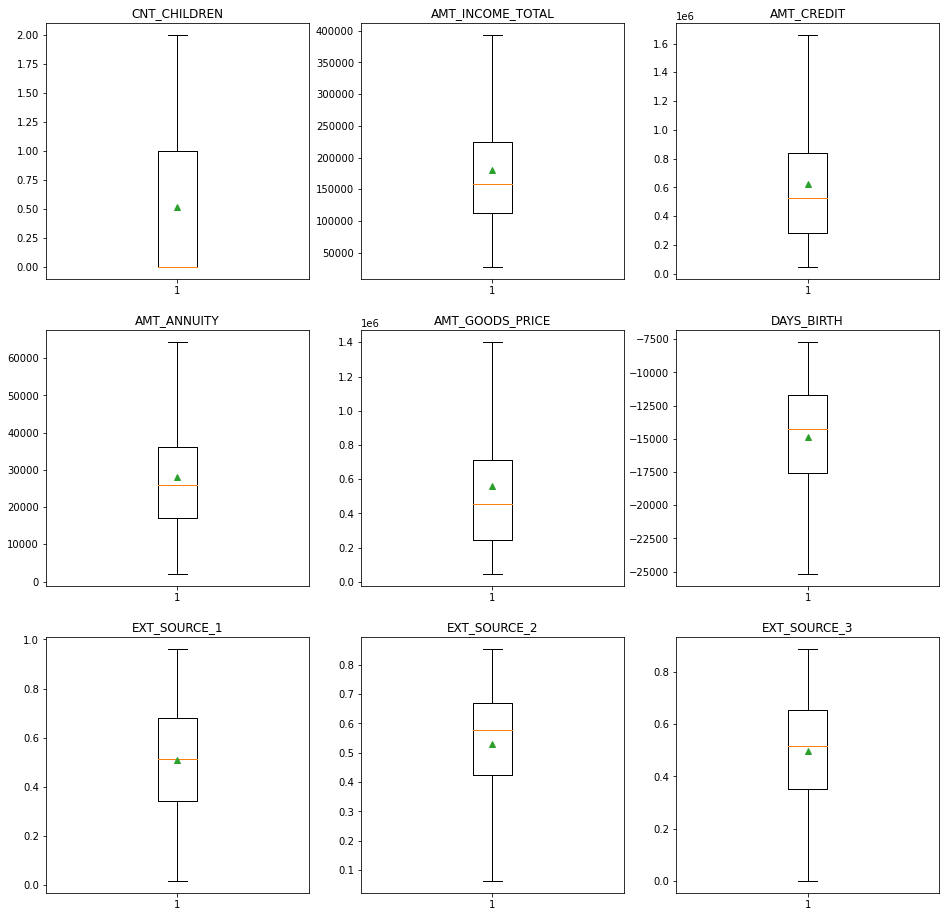

In [164]:
# Distribution des features numériques
plt.figure(figsize=(16,16))
for i, feature in enumerate(list(echantillon.dtypes[(echantillon.dtypes!='object')].index[2:])):
    plt.subplot(3,3,i+1)
    plt.boxplot(echantillon[feature],showmeans=True,showfliers=False)
    plt.title(feature)
plt.savefig('./graphiques/distribution des features numeriques', dpi=300,bbox_inches='tight' )
plt.show()


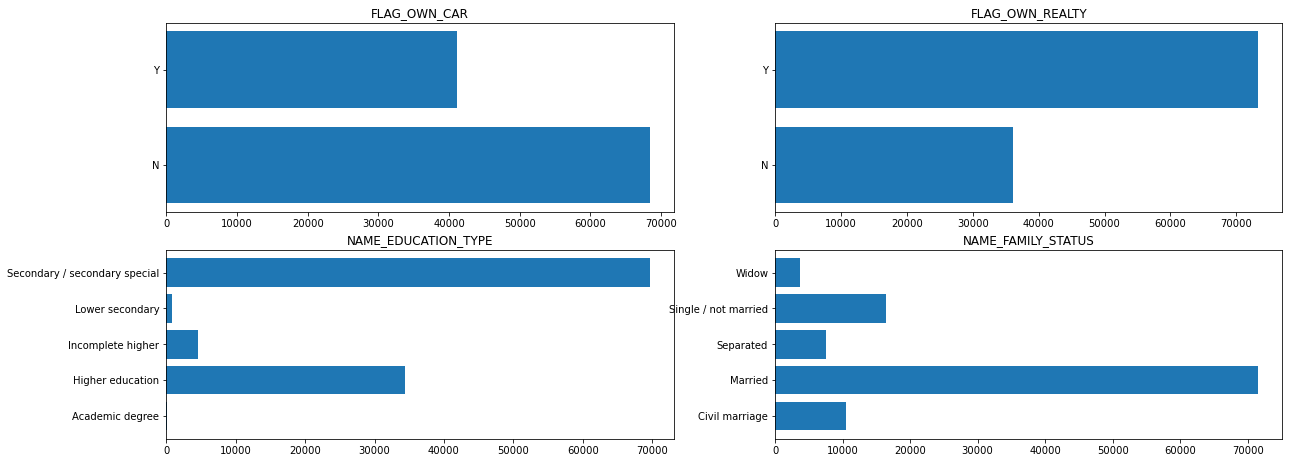

In [165]:
# Répartition par classes des features non numériques
plt.figure(figsize=(20,16))
for i, feature in enumerate(list(echantillon.dtypes[(echantillon.dtypes=='object')].index)):
    comptage=echantillon[feature].groupby(echantillon[feature]).count()
    plt.subplot(4,2,i+1)
    plt.barh(width=comptage,y=echantillon[feature].sort_values().unique())
    plt.title(feature)
plt.savefig('./graphiques/distribution des features de classe', dpi=300,bbox_inches='tight' )
plt.show()

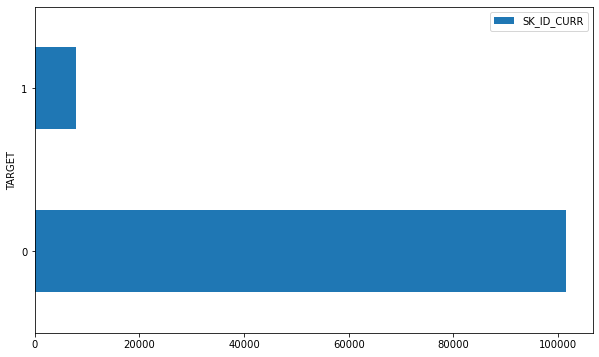

In [166]:
# Repartition des valeurs de TARGET
echantillon[['SK_ID_CURR','TARGET']].groupby('TARGET').count().plot.barh(figsize=(10,6))
plt.savefig('./graphiques/distribution des targets', dpi=300,bbox_inches='tight' )
plt.show()

Remarque : 
des jointures entre les df différents df été réalisées pour générer d'autres échantillons.  
Cependant les nouveaux features disponibles n'apportaient pas d'amélioration significative à la qualité du modèle.  

L'échantillon final, utilisé pour l'entrainement du modèle, reste issu du df application_train uniquement.

# Modèles de classification

In [167]:
from sklearn.pipeline import Pipeline # pour créer le pipeline qui enchaine les étapes de traitement des données
from sklearn.preprocessing import OneHotEncoder # pour encoder les features de type classe
from sklearn.compose import make_column_transformer # pour appliquer un encodage uniquement à certains features
from sklearn.preprocessing import StandardScaler # pour standardiser les données (même importance à chaque features, sans unité)
from sklearn.decomposition import PCA # pour la réduction de dimension 
from sklearn.linear_model import LogisticRegression # pour une prédiction avec la regression logistique (classification)
from sklearn.ensemble import RandomForestClassifier # pour une prediction avec forêt aléatoire (classification)

# pour évaluer le modèle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, fbeta_score, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

### Préparation de la matrice des features X et de la target y

In [168]:
# Matrice de feature X, c'est le df echantillon sans la TARGET
X=echantillon.drop(columns=['SK_ID_CURR','TARGET'])

# La target y
y=echantillon['TARGET']

In [169]:
# Séparation en jeu de train et jeu de test de l'échantillon
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=0, stratify=y) # Garder la proportion des target = 0 et target= 1

In [170]:
# Identification des features de type classe
features_classes = list(echantillon.dtypes[(echantillon.dtypes=='object')].index)

# Encodage uniquement des features de type classe
columns_trans=make_column_transformer((OneHotEncoder(),features_classes),remainder='passthrough')

### 1. Modèle de Régression Logistique

#### 1.1 Pipeline du modèle et entrainement

In [171]:
# Création du pipeline avec 4 étapes
pipeline_LR = Pipeline([
    ('encodeClass',columns_trans), # Encodage des features de type classe
    ('scaler', StandardScaler()), # Ramener les features à une même échelle et sans unité
    ('reducPCA', PCA(n_components = 0.99)), # Décorreler les features et garder 99% de l'inertie totale du nuage de points
    ('regLOG', LogisticRegression(class_weight = "balanced"))  # Classification par régression logistique (avec données déséquilibrées sur la target y)
    ])

In [172]:
# Entrainement du modèle
pipeline_LR.fit(X_train,y_train)

Pipeline(steps=[('encodeClass',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS'])])),
                ('scaler', StandardScaler()),
                ('reducPCA', PCA(n_components=0.99)),
                ('regLOG', LogisticRegression(class_weight='balanced'))])

#### 1.2 Métriques du modèle

In [173]:
# Prédiction du modèle sur le jeu de test
y_pred_LR=pipeline_LR.predict(X_test)

In [174]:
# accuracy_score, qualité du modèle à donner la bonne réponse (justesse) : (VP+VN)/(VP+VN+FP+FN)
accuracy_score(y_true=y_test, y_pred=y_pred_LR)

0.6926062930995114

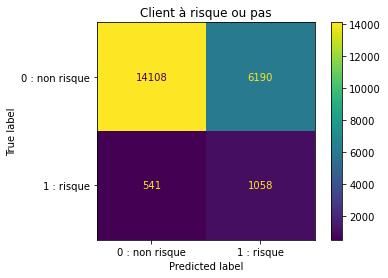

In [175]:
# Matrice de confusion sur le jeu de test
cm_LR=confusion_matrix(y_true=y_test, y_pred=y_pred_LR)
disp_LR=ConfusionMatrixDisplay(cm_LR,display_labels=['0 : non risque','1 : risque'])
disp_LR.plot()
plt.title('Client à risque ou pas')
plt.show()

In [176]:
# fbeta_score, avec beta=2, le RECALL (rappel) est prévilégié dans la métrique.
fbeta_score(y_true=y_test, y_pred=y_pred_LR,beta=2) # avec beta=2, le RECALL (rappel) est prévilégié dans la métrique.

0.38771621225447084

PERTES : Le nombre de faux négatifs est de 541, l'erreur d'accepter des clients avec risque reste assez faible.  
MANQUE A GAGNER : Par contre nombre de faux positif est de 6190, l'erreur de refuser des clients sans risque est fort, c'est un marché perdu pour la société.

### 2. Modèle de classification par forêt aléatoire

#### 2.1 Pipeline du modèle et entrainement

In [177]:
# Création du pipeline avec 4 étapes
pipeline_RF = Pipeline([
    ('encodeClass',columns_trans), # Encodage des features de type classe
    ('scaler', StandardScaler()), # Ramener les features à une même échelle et sans unité
    ('reducPCA', PCA(n_components = 0.99)), # Décorreler les features et garder 99% de l'inertie totale du nuage de points
    ('randomForest', RandomForestClassifier(n_jobs=-1,class_weight='balanced',random_state=1))  # Classification par forêt aléatoire (avec données déséquilibrées sur la target y)
    ])

In [178]:
# Entrainement du modèle
pipeline_RF.fit(X_train,y_train)

Pipeline(steps=[('encodeClass',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS'])])),
                ('scaler', StandardScaler()),
                ('reducPCA', PCA(n_components=0.99)),
                ('randomForest',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=1))])

#### 2.2 Métriques du modèle

In [179]:
# Prédiction du modèle sur le jeu de test
y_pred_RF=pipeline_RF.predict(X_test)

In [180]:
# accuracy_score, qualité du modèle à donner la bonne réponse (justesse) : (VP+VN)/(VP+VN+FP+FN)
accuracy_score(y_true=y_test, y_pred=y_pred_RF)

0.9269306297666347

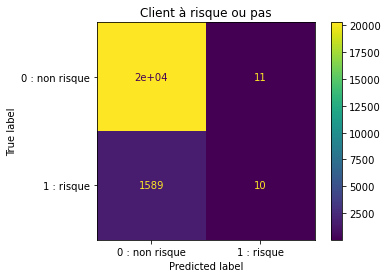

In [181]:
# Matrice de confusion sur le jeu de test
cm_RF=confusion_matrix(y_true=y_test, y_pred=y_pred_RF)
disp_RF=ConfusionMatrixDisplay(cm_RF,display_labels=['0 : non risque','1 : risque'])
disp_RF.plot()
plt.title('Client à risque ou pas')
plt.show()

In [182]:
# fbeta_score, avec beta=2, le RECALL (rappel) est prévilégié dans la métrique.
fbeta_score(y_true=y_test, y_pred=y_pred_RF,beta=2) 

0.007791803023219573

PERTES : Le nombre de faux négatifs est de 1589, l'erreur porte sur 3 fois plus de personnes avec ce modèle de prédiction.  
MANQUE A GAGNER : Par contre le nombre de faux positifs est de 11, l'erreur de refuser des clients sans risque reste faible.

#### Le meilleur modèle

In [183]:
# Le Choix du meilleur modèle, ici la regression logistique
pipeline=pipeline_LR

In [184]:
# Prédictions sur l'échantillon contenu dans le df application_test
echantillon_test=application_test[choix_features[1:]].dropna() # pas de colonne TARGET dans le df
pipeline.predict(echantillon_test[echantillon_test.columns[1:]])

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

In [185]:
# Probabilités de risques de remboursement sur l'échantillon contenu dans le df application_test
pipeline.predict_proba(echantillon_test[echantillon_test.columns[1:]])[:,1]

array([0.35268803, 0.60509631, 0.35629123, ..., 0.66632717, 0.40348736,
       0.40976879])

In [186]:
# Identifiant  des clients à risque dans le df application_test
echantillon_test.SK_ID_CURR[pipeline.predict(echantillon_test[echantillon_test.columns[1:]])==1].values

array([100005, 100067, 100091, ..., 456166, 456189, 456202], dtype=int64)

Cela semble cohérent

# Export des données pour exploitation ultérieure par Streamlit

In [187]:
# Enregistrement des echantillons dans un sous-dossier data

# L'échantillon d'entrainement du modèle
echantillon.to_csv("./data/echantillon.csv",sep=",",encoding="utf-8",index=False)

# La base de test client
echantillon_test.to_csv("./data/echantillon_test.csv",sep=",",encoding="utf-8",index=False)

# Enregistrement de l'objet pipeline pour l'API

In [188]:
import joblib
joblib.dump(pipeline, 'pipeline_scoring.joblib',compress=3)

['pipeline_scoring.joblib']

# Enregistrement de  l'objet signature pour l'API

In [189]:
# Signature d'un modèle
# La signature du modèle permet de renseigner le nom des colonnes et leurs types afin de vérifier si ils sont similaires lors de la prédiction.
from mlflow.models.signature import infer_signature
signature = infer_signature(X, y)

In [190]:
joblib.dump(signature,'signature_MLflow.joblib')

['signature_MLflow.joblib']